## Problem 1 Handwritten Digit Recognition

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn

/home/rongzhid/miniconda3/envs/csce790/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_hip.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# converts the image into tensors and then normalize
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

In [3]:
# load dataset
trainset = datasets.MNIST('./MNIST_train', download=True, train=True, transform=transform)
valset = datasets.MNIST('./MNIST_test', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

In [4]:
# load image and lables iteratively
dataiter = iter(trainloader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


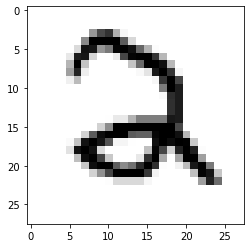

In [5]:
# show the first image in the training set
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r');

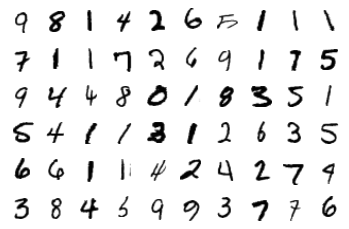

In [6]:
# show a random 6 x 10 figure matrix
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [7]:
# build a NN with input layer two hidden layer and a output layer
# using ReLu activate function
# using softmax to classify 
input_size = 784 
hidden_sizes = [128, 64]
output_size = 10

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


In [8]:
# define loss function
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

In [9]:
# show how backpropagation update weights
print('Before backward pass: \n', model[0].weight.grad)
loss.backward()
print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[ 0.0012,  0.0012,  0.0012,  ...,  0.0012,  0.0012,  0.0012],
        [ 0.0004,  0.0004,  0.0004,  ...,  0.0004,  0.0004,  0.0004],
        [ 0.0084,  0.0084,  0.0084,  ...,  0.0084,  0.0084,  0.0084],
        ...,
        [-0.0002, -0.0002, -0.0002,  ..., -0.0002, -0.0002, -0.0002],
        [ 0.0004,  0.0004,  0.0004,  ...,  0.0004,  0.0004,  0.0004],
        [ 0.0005,  0.0005,  0.0005,  ...,  0.0005,  0.0005,  0.0005]])


### Way1: Design a new optimizer

In [16]:
# Optimizer 
class Optimizer(torch.optim.Optimizer): 
      
    # Init Method: 
    def __init__(self, params, lr=1e-3, momentum=0.9): 
        super(Optimizer, self).__init__(params, defaults={'lr': lr}) 
        self.momentum = momentum 
        self.state = dict() 
        for group in self.param_groups: 
            for p in group['params']: 
                self.state[p] = dict(mom=torch.zeros_like(p.data)) 
      
    # Step Method 
    def step(self): 
        for group in self.param_groups: 
            for p in group['params']: 
                if p not in self.state: 
                    self.state[p] = dict(mom=torch.zeros_like(p.data)) 
                mom = self.state[p]['mom'] 
                mom = self.momentum * mom - group['lr'] * p.grad.data 
                p.data += mom
                

In [17]:
# model training
# change the torch.nn.optimizer to customized optimer class as defined in previous cell
optimizer = Optimizer(model.parameters(), lr=0.003, momentum=0.9)
time0 = time()
epochs = 100
train_loss =[]
valid_loss =[]
for e in range(epochs):
    training_loss = 0
    validation_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        training_loss += loss.item()
    else:
        train_loss.append(training_loss/len(trainloader))
#         print("Epoch {} - Training loss: {}".format(e, training_loss/len(trainloader)))
    for images, labels in valloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)

        output = model(images)
        loss = criterion(output, labels)

        validation_loss += loss.item()
    else:
        valid_loss.append(validation_loss/len(valloader))
    print("Epoch {} - Training loss: {} - Validation loss: {}".format(e, training_loss/len(trainloader), validation_loss/len(valloader)))

print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 0 - Training loss: 1.924675714867964 - Validation loss: 1.2984890125359698
Epoch 1 - Training loss: 0.8805683947511828 - Validation loss: 0.6068630579170907
Epoch 2 - Training loss: 0.5286540417655953 - Validation loss: 0.45088473190167905
Epoch 3 - Training loss: 0.43171435140216274 - Validation loss: 0.39231639521516815
Epoch 4 - Training loss: 0.3876593473560012 - Validation loss: 0.36198927917677887
Epoch 5 - Training loss: 0.3615511039585701 - Validation loss: 0.34088666029986303
Epoch 6 - Training loss: 0.34313800063595845 - Validation loss: 0.32503112614344637
Epoch 7 - Training loss: 0.32888811898987685 - Validation loss: 0.31264532727610533
Epoch 8 - Training loss: 0.3171790351491493 - Validation loss: 0.30431592298351273
Epoch 9 - Training loss: 0.3067002492799942 - Validation loss: 0.29574814889651196
Epoch 10 - Training loss: 0.29750921193565893 - Validation loss: 0.28441419775129123
Epoch 11 - Training loss: 0.2892841614210911 - Validation loss: 0.2813769111967391
Ep

Epoch 98 - Training loss: 0.06147626142597386 - Validation loss: 0.0941818802125135
Epoch 99 - Training loss: 0.06079959447708116 - Validation loss: 0.09056722408955455

Training Time (in minutes) = 23.7944122672081


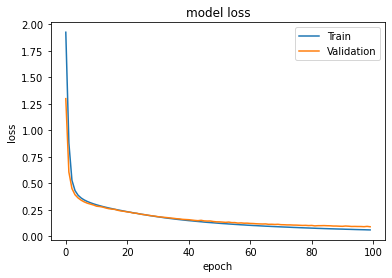

In [18]:
# plot the training and validation loss curve
import matplotlib.pyplot as plt

plt.plot(train_loss)
plt.plot(valid_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
# plt.savefig('MNIST model loss.pdf', format='pdf')
plt.show()

In [19]:
# show the image and corresponding class probability
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.cpu().data.numpy().squeeze()
    
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

Predicted Digit = 9


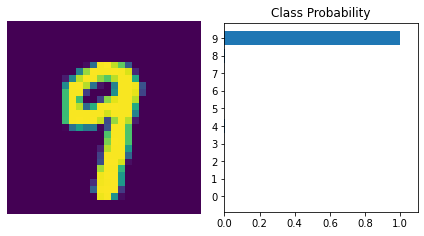

In [20]:
# test model
images, labels = next(iter(valloader))
img = images[0].view(1, 784)
with torch.no_grad():
    logps = model(img)
# print(logps)
ps = torch.exp(logps)
# print(ps)
probab = list(ps.numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
view_classify(img.view(1, 28, 28), ps)

In [21]:
# calculate the accuracy
correct_count, all_count = 0, 0
for images,labels in valloader:
    for i in range(len(labels)):
        img = images[i].view(1, 784)
        with torch.no_grad():
            logps = model(img)
        ps = torch.exp(logps)
        probab = list(ps.numpy()[0])
        pred_label = probab.index(max(probab))
        true_label = labels.numpy()[i]
        if(true_label == pred_label):
            correct_count += 1
        all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.9717


In [22]:
torch.save(model, './my_mnist_model1.pt') 

### Way2: Update parameters directely 

In [26]:
# create a new model
model1 = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
print(model1)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


In [27]:
# model training
time0 = time()
epochs = 100
train_loss1 =[]
valid_loss1 =[]
lr = 0.005
for e in range(epochs):
    training_loss = 0
    validation_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # Training pass
        model1.zero_grad()
        output = model1(images)
        loss = criterion(output, labels)
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        with torch.no_grad():    
            for param in model1.parameters():
                param -= lr* param.grad
        
        
        training_loss += loss.item()
    else:
        train_loss1.append(training_loss/len(trainloader))
   
    
#         print("Epoch {} - Training loss: {}".format(e, training_loss/len(trainloader)))
    for images, labels in valloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)

        output = model1(images)
        loss = criterion(output, labels)

        validation_loss += loss.item()
    else:
        valid_loss1.append(validation_loss/len(valloader))
    print("Epoch {} - Training loss: {} - Validation loss: {}".format(e, training_loss/len(trainloader), validation_loss/len(valloader)))

print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 0 - Training loss: 1.5217275671613242 - Validation loss: 0.7476367977014773
Epoch 1 - Training loss: 0.5712776720555607 - Validation loss: 0.4413536476671316
Epoch 2 - Training loss: 0.41115970768209203 - Validation loss: 0.3618910301263165
Epoch 3 - Training loss: 0.3570918571958537 - Validation loss: 0.33012757825244005
Epoch 4 - Training loss: 0.32768586451120213 - Validation loss: 0.30270416417698953
Epoch 5 - Training loss: 0.3073827865869125 - Validation loss: 0.29868698328923265
Epoch 6 - Training loss: 0.2909694162449603 - Validation loss: 0.27800796774162606
Epoch 7 - Training loss: 0.27591826518906204 - Validation loss: 0.263123172103979
Epoch 8 - Training loss: 0.26227186223877264 - Validation loss: 0.2504658249153453
Epoch 9 - Training loss: 0.2500919825169069 - Validation loss: 0.24085529860417554
Epoch 10 - Training loss: 0.23789804472105464 - Validation loss: 0.2303574462747498
Epoch 11 - Training loss: 0.22708247236208493 - Validation loss: 0.21584928040481677
Epo

Epoch 97 - Training loss: 0.026710483697808977 - Validation loss: 0.0718050979783723
Epoch 98 - Training loss: 0.026139680315792037 - Validation loss: 0.07299176710034916
Epoch 99 - Training loss: 0.0256908123526893 - Validation loss: 0.07200447749939694

Training Time (in minutes) = 24.012552599112194


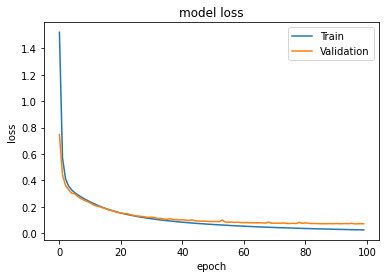

In [28]:
# plot the training and validation loss curve
import matplotlib.pyplot as plt

plt.plot(train_loss1)
plt.plot(valid_loss1)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
# plt.savefig('MNIST model loss.pdf', format='pdf')
plt.show()

In [29]:
# show the image and corresponding class probability
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.cpu().data.numpy().squeeze()
    
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

Predicted Digit = 0


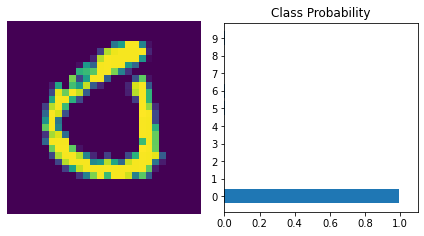

In [30]:
# test model
images, labels = next(iter(valloader))
img = images[0].view(1, 784)
with torch.no_grad():
    logps = model1(img)
# print(logps)
ps = torch.exp(logps)
# print(ps)
probab = list(ps.numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
view_classify(img.view(1, 28, 28), ps)

In [31]:
# calculate the accuracy
correct_count, all_count = 0, 0
for images,labels in valloader:
    for i in range(len(labels)):
        img = images[i].view(1, 784)
        with torch.no_grad():
            logps = model1(img)
        ps = torch.exp(logps)
        probab = list(ps.numpy()[0])
        pred_label = probab.index(max(probab))
        true_label = labels.numpy()[i]
        if(true_label == pred_label):
            correct_count += 1
        all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.978


### Way3: Rewrite the NN architecture but the results are not good

In [32]:
#Sigmoid funstion
def sigmoid(x):
    return 1/(np.exp(-x)+1)    

#derivative of sigmoid
def sigmoid_derivative(x):
    return (np.exp(-x))/((np.exp(-x)+1)**2)

# Define the tanh activation function and its derivative
def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1-np.tanh(x)**2

#Softmax|
def softmax(x):
    exp_element=np.exp(x-x.max())
    return exp_element/np.sum(exp_element,axis=0)

#derivative of softmax
def softmax_derivative(x):
    exp_element=np.exp(x-x.max())
    return exp_element/np.sum(exp_element,axis=0)*(1-exp_element/np.sum(exp_element,axis=0))

In [33]:
# build a NN with input layer two hidden layer and a output layer
# using ReLu activate function
# using softmax to classify
np.random.seed(0)  # For reproducibility
input_size = 28*28 
hidden_size = 128
output_size = 10

# Initialize weights and biases
def init(x,y):
    layer=np.random.uniform(-1.,1.,size=(x,y))/np.sqrt(x*y)
    return layer.astype(np.float32)

W1 = init(input_size, hidden_size)
# B1 = np.zeros(batch_size,hidden_size)) # biases is not suitable beacuse the last batch has fewer imgs then batchsize
W2 = init(hidden_size,output_size)
# B2 = np.zeros(batch_size,output_size))

In [34]:
#forward and backward pass using sigmoid
def forward_backward_pass_sigmoid(x,y):
    targets = np.zeros((len(y),10), np.float32)
    targets[range(targets.shape[0]),y] = 1
 
    x_l1=x.dot(W1)
    x_sigmoid=sigmoid(x_l1)
    x_l2=x_sigmoid.dot(W2)
    out=softmax(x_l2)
 
    error=2*(out-targets)/out.shape[0]*softmax_derivative(x_l2)
    update_W2=x_sigmoid.T@error
    
    error=((W2).dot(error.T)).T*sigmoid_derivative(x_l1)
    update_W1=x.T@error

    return out,update_W1,update_W2 

#forward and backward pass using tanh
def forward_backward_pass_tanh(x,y):
    targets = np.zeros((len(y),10), np.float32)
    targets[range(targets.shape[0]),y] = 1
 
    x_l1=x.dot(W1)
    x_tanh=tanh(x_l1)
    x_l2=x_tanh.dot(W2)
    out=softmax(x_l2)
 
    error=2*(out-targets)/out.shape[0]*softmax_derivative(x_l2)
    update_W2=x_tanh.T@error
    
    error=((W2).dot(error.T)).T*tanh_derivative(x_l1)
    update_W1=x.T@error

    return out,update_W1,update_W2 

In [35]:
# Define hyperparameters
lr = 0.001
epochs = 25

# Define the input and target data
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

In [36]:
# model training
time0 = time()
train_loss =[]
valid_loss =[]
train_acc, valid_acc = [], []
for e in range(epochs):
    training_loss = 0
    validation_loss = 0
    training_acc = 0
    validation_acc = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
        
        # Forward pass
        input_layer = images
        
        y_pred,update_W1,update_W2 = forward_backward_pass_tanh(images.numpy(), labels.numpy())
        W1 -= lr*update_W1
        W2 -= lr*update_W2
        
        # Compute error
        y_true = np.zeros((len(labels),10), np.float32)
        y_true[range(y_true.shape[0]),labels] = 1
        category = np.argmax(y_pred,axis=1)
        loss=((category-labels.numpy())**2).mean()
        accuracy=(category==labels.numpy()).mean()
        training_loss += loss.item()
        training_acc += accuracy.item()
    else:
        train_loss.append(training_loss/len(trainloader))
        train_acc.append(training_acc/len(trainloader))
#         print("Epoch {} - Training loss: {}".format(e, training_loss/len(trainloader)))
    for images, labels in valloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
        
        # Forward pass
        input_layer = images
        
        y_pred,update_W1,update_W2 = forward_backward_pass_tanh(images.numpy(), labels.numpy())
        W1 -= lr*update_W1
        W2 -= lr*update_W2
        
        # Compute error
        y_true = np.zeros((len(labels),10), np.float32)
        y_true[range(y_true.shape[0]),labels] = 1
        category = np.argmax(y_pred,axis=1)
        loss=((category-labels.numpy())**2).mean()
        accuracy=(category==labels.numpy()).mean()
        validation_loss += loss.item()
        validation_acc += accuracy.item()
    else:
        valid_loss.append(validation_loss/len(valloader))
        valid_acc.append(validation_acc/len(valloader))
    print(f"Epoch {e} - Training loss: {training_loss/len(trainloader):.3f} - Validation loss: {validation_loss/len(valloader):.3f}- Training acc: {training_acc/len(trainloader):.3f} - Validation acc: {validation_acc/len(valloader):.3f}")

print("\nTraining Time (in minutes) =",(time()-time0)/60)


Epoch 0 - Training loss: 16.398 - Validation loss: 11.974- Training acc: 0.224 - Validation acc: 0.377
Epoch 1 - Training loss: 9.947 - Validation loss: 8.492- Training acc: 0.470 - Validation acc: 0.535
Epoch 2 - Training loss: 8.041 - Validation loss: 7.465- Training acc: 0.573 - Validation acc: 0.604
Epoch 3 - Training loss: 7.480 - Validation loss: 7.211- Training acc: 0.614 - Validation acc: 0.629
Epoch 4 - Training loss: 7.303 - Validation loss: 7.107- Training acc: 0.631 - Validation acc: 0.641
Epoch 5 - Training loss: 7.226 - Validation loss: 7.056- Training acc: 0.640 - Validation acc: 0.646
Epoch 6 - Training loss: 7.212 - Validation loss: 7.055- Training acc: 0.643 - Validation acc: 0.648
Epoch 7 - Training loss: 7.228 - Validation loss: 7.004- Training acc: 0.645 - Validation acc: 0.650
Epoch 8 - Training loss: 7.214 - Validation loss: 7.057- Training acc: 0.643 - Validation acc: 0.649
Epoch 9 - Training loss: 7.315 - Validation loss: 7.140- Training acc: 0.642 - Validation

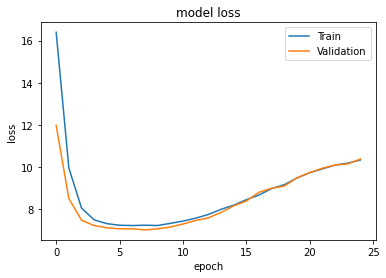

In [37]:
# plot the training and validation loss curve
import matplotlib.pyplot as plt

plt.plot(train_loss)
plt.plot(valid_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
# plt.savefig('MNIST model loss.pdf', format='pdf')
plt.show()

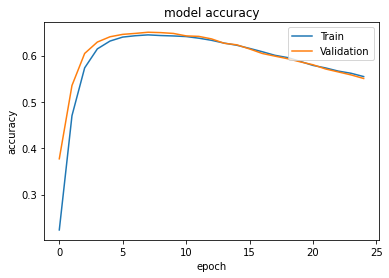

In [38]:
# plot the training and validation accuracy curve
import matplotlib.pyplot as plt

plt.plot(train_acc)
plt.plot(valid_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
# plt.savefig('MNIST model acc.pdf', format='pdf')
plt.show()

In [39]:
# show the image and corresponding class probability
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.cpu().data.numpy().squeeze()
    
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

torch.Size([1, 784])
[0]
Predicted Digit = 0


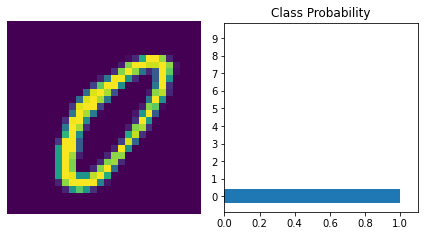

In [40]:
# test model
images, labels = next(iter(valloader))
img = images[0].view(1, 784)
print(img.shape)

y_pred = softmax(tanh(img.numpy().dot(W1)).dot(W2))
category = np.argmax(y_pred,axis=1)
print(category)
probs = np.zeros((len(img),10), np.float32)
probs[range(probs.shape[0]),category] = 1
ps = torch.tensor(probs)
# print(ps)
print("Predicted Digit =", category[0])
view_classify(img.view(1, 28, 28), ps)

In [42]:
# calculate the accuracy
correct_count, all_count = 0, 0
for images,labels in valloader:
    for i in range(len(labels)):
        img = images[i].view(1, 784)
        pred_label = np.argmax(softmax(tanh(img.numpy().dot(W1)).dot(W2)),axis=1)
        true_label = labels.numpy()[i]
        if(true_label == pred_label):
            correct_count += 1
        all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.098
